In [ ]:
!pip install -q torchvision matplotlib scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 102.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.2 MB/s eta 0:00:00


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class LOLPairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.low_dir = os.path.join(root_dir, 'low')
        self.high_dir = os.path.join(root_dir, 'high')
        self.image_names = sorted([
            name for name in os.listdir(self.low_dir)
            if name.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.transform = transform if transform else transforms.ToTensor()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_path = os.path.join(self.low_dir, self.image_names[idx])
        high_path = os.path.join(self.high_dir, self.image_names[idx])
        low_img = Image.open(low_path).convert("RGB")
        high_img = Image.open(high_path).convert("RGB")
        return self.transform(low_img), self.transform(high_img)



In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

In [ ]:
dataset_path = "/content/drive/MyDrive/low_light_project/LOL_dataset/our485/"
dataset = LOLPairDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [ ]:
import torch
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU()
            )
        self.down1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.middle = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        mid = self.middle(p2)

        up2 = self.up2(mid)
        cat2 = torch.cat([up2, d2], dim=1)
        dec2 = self.dec2(cat2)

        up1 = self.up1(dec2)
        cat1 = torch.cat([up1, d1], dim=1)
        dec1 = self.dec1(cat1)

        return self.final(dec1)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Eğitim döngüsü
for epoch in range(50):
    model.train()
    epoch_loss = 0
    for low_img, high_img in dataloader:
        low_img = low_img.to(device)
        high_img = high_img.to(device)

        optimizer.zero_grad()
        output = model(low_img)
        loss = criterion(output, high_img)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1 - Loss: 0.0767
Epoch 2 - Loss: 0.0338
Epoch 3 - Loss: 0.0313
Epoch 4 - Loss: 0.0296
Epoch 5 - Loss: 0.0301
Epoch 6 - Loss: 0.0282
Epoch 7 - Loss: 0.0282
Epoch 8 - Loss: 0.0276
Epoch 9 - Loss: 0.0269
Epoch 10 - Loss: 0.0259
Epoch 11 - Loss: 0.0256
Epoch 12 - Loss: 0.0257
Epoch 13 - Loss: 0.0258
Epoch 14 - Loss: 0.0249
Epoch 15 - Loss: 0.0251
Epoch 16 - Loss: 0.0241
Epoch 17 - Loss: 0.0245
Epoch 18 - Loss: 0.0243
Epoch 19 - Loss: 0.0253
Epoch 20 - Loss: 0.0246
Epoch 21 - Loss: 0.0237
Epoch 22 - Loss: 0.0235
Epoch 23 - Loss: 0.0232
Epoch 24 - Loss: 0.0233
Epoch 25 - Loss: 0.0224
Epoch 26 - Loss: 0.0236
Epoch 27 - Loss: 0.0228
Epoch 28 - Loss: 0.0227
Epoch 29 - Loss: 0.0226
Epoch 30 - Loss: 0.0218
Epoch 31 - Loss: 0.0218
Epoch 32 - Loss: 0.0221
Epoch 33 - Loss: 0.0220
Epoch 34 - Loss: 0.0216
Epoch 35 - Loss: 0.0224
Epoch 36 - Loss: 0.0216
Epoch 37 - Loss: 0.0218
Epoch 38 - Loss: 0.0225
Epoch 39 - Loss: 0.0213
Epoch 40 - Loss: 0.0219
Epoch 41 - Loss: 0.0228
Epoch 42 - Loss: 0.0213
E

In [ ]:
torch.save(model.state_dict(), "unet_model_mse.pth")

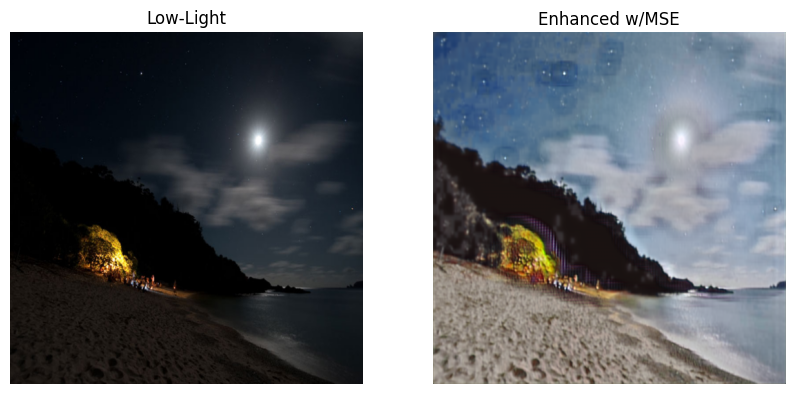

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
model.load_state_dict(torch.load("unet_model_mse.pth", map_location=device))
model.eval()

# Görseli yükle ve modele uygun şekilde dönüştür
img = Image.open("/content/lowlight.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Modeli değerlendirme moduna al
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Görselleştir
low_np = input_tensor[0].cpu().permute(1, 2, 0).numpy()
out_np = output[0].cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Low-Light"); plt.imshow(low_np.clip(0,1)); plt.axis("off")
plt.subplot(1,2,2); plt.title("Enhanced w/MSE"); plt.imshow(out_np.clip(0,1)); plt.axis("off")
plt.show()

In [ ]:
from PIL import Image

img = Image.open("/content/drive/MyDrive/low_light_project/LOL_dataset/eval15/low/493.png").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)


In [ ]:
model.eval()
with torch.no_grad():
    output = model(input_tensor)

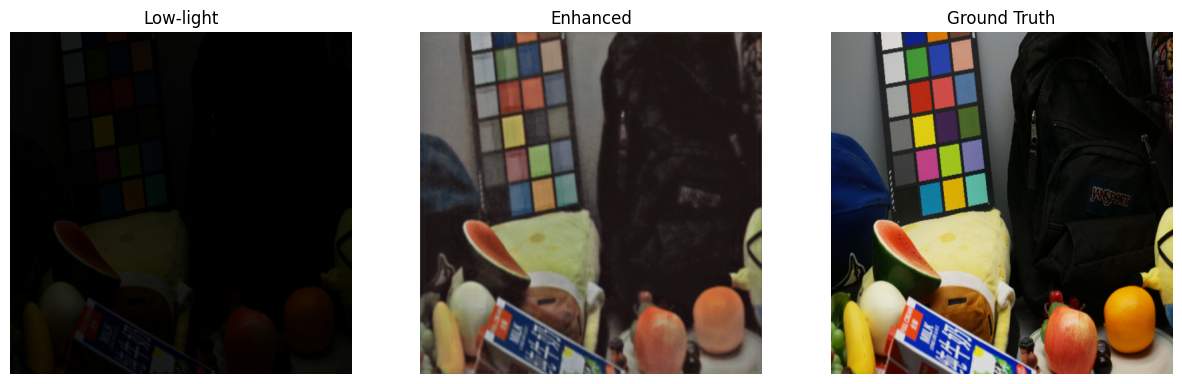

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for low_img, high_img in dataloader:
        low_img = low_img.to(device)
        output = model(low_img)
        break  # sadece ilk batch

low_np = low_img[0].cpu().permute(1, 2, 0).numpy()
high_np = high_img[0].permute(1, 2, 0).numpy()
out_np = output[0].cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Low-light"); plt.imshow(low_np); plt.axis("off")
plt.subplot(1,3,2); plt.title("Enhanced"); plt.imshow(out_np.clip(0,1)); plt.axis("off")
plt.subplot(1,3,3); plt.title("Ground Truth"); plt.imshow(high_np); plt.axis("off")
plt.show()


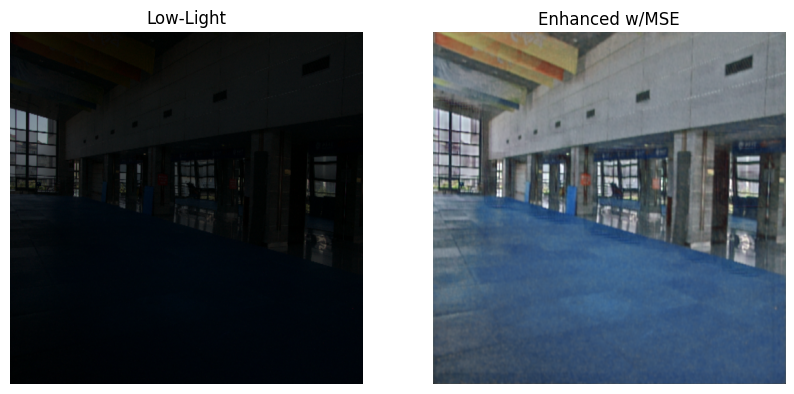

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/drive/MyDrive/low_light_project/LOL_dataset/eval15/low/780.png").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)

# Görselleştir
low_np = input_tensor[0].cpu().permute(1, 2, 0).numpy()
out_np = output[0].cpu().permute(1, 2, 0).numpy()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Low-Light"); plt.imshow(low_np.clip(0,1)); plt.axis("off")
plt.subplot(1,2,2); plt.title("Enhanced w/MSE"); plt.imshow(out_np.clip(0,1)); plt.axis("off")
plt.show()


In [ ]:
class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        vgg = models.vgg16(pretrained=True).features[:16].eval()  # conv3_3'e kadar
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg
        self.criterion = nn.MSELoss()

    def forward(self, x, y):
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        y = F.interpolate(y, size=(224, 224), mode='bilinear', align_corners=False)
        return self.criterion(self.vgg(x), self.vgg(y))


In [ ]:
import torchvision.models as models

model = UNet().to(device)
mse_loss = nn.MSELoss()
perc_loss = VGGPerceptualLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
lambda_vgg = 0.1

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 233MB/s]


In [ ]:
perc_loss = VGGPerceptualLoss().to(device)

In [ ]:
from torchvision.utils import save_image
import torch.nn.functional as F

num_epochs = 50
lambda_vgg = 0.1

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for low_img, high_img in dataloader:
        low_img = low_img.to(device)
        high_img = high_img.to(device)

        optimizer.zero_grad()

        output = model(low_img)
        loss_mse = mse_loss(output, high_img)
        loss_perc = perc_loss(output, high_img)
        loss = loss_mse + lambda_vgg * loss_perc

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            output_vis = model(low_img)[0].cpu().detach()
            save_image(output_vis, f"enhanced_epoch{epoch+1}.jpg")
            print(f"✅: enhanced_epoch{epoch+1}.jpg")


Epoch 1/50 - Loss: 0.1388
Epoch 2/50 - Loss: 0.1085
Epoch 3/50 - Loss: 0.0921
Epoch 4/50 - Loss: 0.0865
Epoch 5/50 - Loss: 0.0820
✅: enhanced_epoch5.jpg
Epoch 6/50 - Loss: 0.0772
Epoch 7/50 - Loss: 0.0755
Epoch 8/50 - Loss: 0.0736
Epoch 9/50 - Loss: 0.0722
Epoch 10/50 - Loss: 0.0708
✅: enhanced_epoch10.jpg
Epoch 11/50 - Loss: 0.0717
Epoch 12/50 - Loss: 0.0684
Epoch 13/50 - Loss: 0.0688
Epoch 14/50 - Loss: 0.0681
Epoch 15/50 - Loss: 0.0673
✅: enhanced_epoch15.jpg
Epoch 16/50 - Loss: 0.0668
Epoch 17/50 - Loss: 0.0674
Epoch 18/50 - Loss: 0.0665
Epoch 19/50 - Loss: 0.0655
Epoch 20/50 - Loss: 0.0649
✅: enhanced_epoch20.jpg
Epoch 21/50 - Loss: 0.0654
Epoch 22/50 - Loss: 0.0656
Epoch 23/50 - Loss: 0.0649
Epoch 24/50 - Loss: 0.0643
Epoch 25/50 - Loss: 0.0635
✅: enhanced_epoch25.jpg
Epoch 26/50 - Loss: 0.0632
Epoch 27/50 - Loss: 0.0637
Epoch 28/50 - Loss: 0.0627
Epoch 29/50 - Loss: 0.0623
Epoch 30/50 - Loss: 0.0643
✅: enhanced_epoch30.jpg
Epoch 31/50 - Loss: 0.0631
Epoch 32/50 - Loss: 0.0625
Ep

In [ ]:
torch.save(model.state_dict(), "unet_vgg_model.pth")

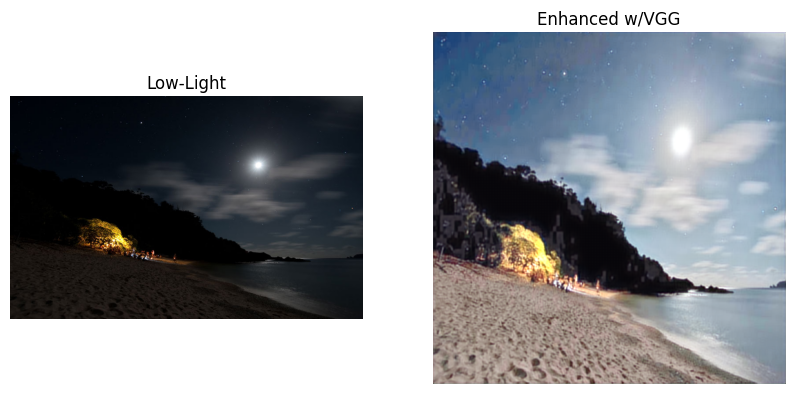

In [ ]:
img = Image.open("/content/lowlight.jpg").convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
model.load_state_dict(torch.load("unet_vgg_model.pth", map_location=device))
model.eval()

model.eval()
with torch.no_grad():
    output = model(input_tensor)

output_np = output.squeeze().permute(1, 2, 0).cpu().numpy().clip(0, 1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Low-Light"); plt.imshow(img); plt.axis("off")
plt.subplot(1,2,2); plt.title("Enhanced w/VGG"); plt.imshow(output_np); plt.axis("off")
plt.show()


In [ ]:
!pip install pytorch-msssim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

In [ ]:
print(low_img.min(), low_img.max())


tensor(0., device='cuda:0') tensor(0.8118, device='cuda:0')


In [ ]:
import torch.nn.functional as F
from tqdm import tqdm
from pytorch_msssim import ssim

num_epochs = 50
lambda_vgg = 0.1
lambda_ssim = 0.1

model = UNet().to(device)
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for low_img, high_img in dataloader:
        low_img = low_img.to(device)
        high_img = high_img.to(device)

        optimizer.zero_grad()
        output = model(low_img)

        loss_mse = mse_loss(output, high_img)
        loss_vgg = perc_loss(output, high_img)
        loss_ssim = 1 - ssim(output, high_img, data_range=1.0)

        loss = loss_mse + lambda_vgg * loss_vgg + lambda_ssim * loss_ssim

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")


Epoch 1/50, Loss: 0.6357
Epoch 2/50, Loss: 0.6343
Epoch 3/50, Loss: 0.6366
Epoch 4/50, Loss: 0.6341
Epoch 5/50, Loss: 0.6364
Epoch 6/50, Loss: 0.6361
Epoch 7/50, Loss: 0.6355
Epoch 8/50, Loss: 0.6349
Epoch 9/50, Loss: 0.6344
Epoch 10/50, Loss: 0.6349
Epoch 11/50, Loss: 0.6361
Epoch 12/50, Loss: 0.6343
Epoch 13/50, Loss: 0.6348
Epoch 14/50, Loss: 0.6366
Epoch 15/50, Loss: 0.6349
Epoch 16/50, Loss: 0.6357
Epoch 17/50, Loss: 0.6354
Epoch 18/50, Loss: 0.6352
Epoch 19/50, Loss: 0.6336
Epoch 20/50, Loss: 0.6354
Epoch 21/50, Loss: 0.6369
Epoch 22/50, Loss: 0.6349
Epoch 23/50, Loss: 0.6361
Epoch 24/50, Loss: 0.6364
Epoch 25/50, Loss: 0.6362
Epoch 26/50, Loss: 0.6364
Epoch 27/50, Loss: 0.6352
Epoch 28/50, Loss: 0.6366
Epoch 29/50, Loss: 0.6364
Epoch 30/50, Loss: 0.6373
Epoch 31/50, Loss: 0.6348
Epoch 32/50, Loss: 0.6341
Epoch 33/50, Loss: 0.6352
Epoch 34/50, Loss: 0.6358
Epoch 35/50, Loss: 0.6345
Epoch 36/50, Loss: 0.6349
Epoch 37/50, Loss: 0.6348
Epoch 38/50, Loss: 0.6370
Epoch 39/50, Loss: 0.

**EnlighgtenGAN**

In [ ]:
!pip install onnxruntime opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/arsenyinfo/EnlightenGAN-inference.git
%cd EnlightenGAN-inference

Cloning into 'EnlightenGAN-inference'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 29 (delta 4), reused 2 (delta 2), pack-reused 20 (from 1)
Receiving objects: 100% (29/29), 30.63 MiB | 46.54 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/EnlightenGAN-inference


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.7 MB/s eta 0:00:00


In [ ]:
import cv2
from enlighten_inference import EnlightenOnnxModel

img = cv2.imread('/content/lowlight.jpg')

model = EnlightenOnnxModel(providers=["CUDAExecutionProvider"])
enhanced = model.predict(img)


In [ ]:
import cv2
import numpy as np
enhanced_uint8 = np.clip(enhanced, 0, 255).astype(np.uint8)

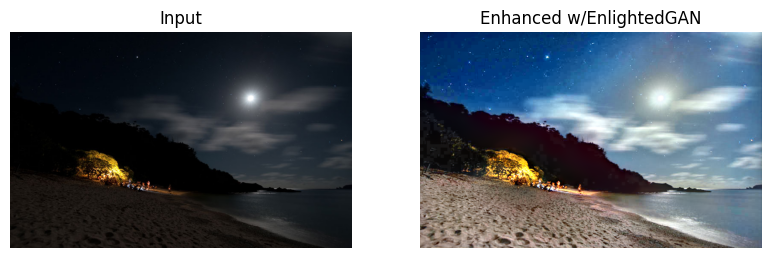

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.title("Input"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(1,3,2); plt.title("Enhanced w/EnlightedGAN"); plt.imshow(cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.show()

In [ ]:
import cv2
import torch
import torch.nn.functional as F
import onnxruntime as ort
import numpy as np
from torchvision import transforms
from enlighten_inference import EnlightenOnnxModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet_model = UNet().to(device)
unet_model.load_state_dict(torch.load("/content/unet_model_mse.pth", map_location=device))
unet_model.eval()

vgg_model = UNet().to(device)
vgg_model.load_state_dict(torch.load("/content/unet_vgg_model.pth", map_location=device))
vgg_model.eval()

enlighten_model = EnlightenOnnxModel(providers=["CUDAExecutionProvider"])


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

def predict_unet(model, img_rgb):
    img_tensor = transform(img_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        output = torch.clamp(output, 0, 1)
    output = output.squeeze(0).cpu().permute(1, 2, 0).numpy()
    return (output * 255).astype(np.uint8)


def predict_enlighten(model, img_rgb):
    return model.predict(img_rgb)



In [ ]:
video_path = '/content/test2.mp4'
cap = cv2.VideoCapture(video_path)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_unet = cv2.VideoWriter('output_unet.mp4', fourcc, fps, (width, height))
out_vgg = cv2.VideoWriter('output_vgg.mp4', fourcc, fps, (width, height))
out_enlighten = cv2.VideoWriter('output_enlighten.mp4', fourcc, fps, (width, height))


In [ ]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    pred_unet = predict_unet(unet_model, img_rgb)
    pred_vgg = predict_unet(vgg_model, img_rgb)
    pred_enlighten = predict_enlighten(enlighten_model, img_rgb)

    pred_unet = cv2.cvtColor(pred_unet, cv2.COLOR_RGB2BGR)
    pred_vgg = cv2.cvtColor(pred_vgg, cv2.COLOR_RGB2BGR)
    pred_enlighten = cv2.cvtColor(pred_enlighten, cv2.COLOR_RGB2BGR)

    out_unet.write(pred_unet)
    out_vgg.write(pred_vgg)
    out_enlighten.write(pred_enlighten)

cap.release()
out_unet.release()
out_vgg.release()
out_enlighten.release()
cv2.destroyAllWindows()
